# ML Final Project

In this final project, I will analyze a dataset containing loan eligibility data. The goal is to accurately classify if a loan will be approved based on its features. There are 614 observations. The dataset has 13 columns including one unique ID (Loan_ID) and the target variable. The descriptions of the columns are below.
 
| Columns	| Description |
| :-----------: | :-----------: |
| Loan_ID	| Unique Job ID |
| Gender	| Male/Female |
| Married	| Applicant married (Y/N) |
| Dependents	| Number of dependents |
| Education	| Applicant Education (Graduate/Not Graduate)|
| Self_Employed	| Self employed (Y/N) |
| ApplicantIncome	| Applicant income |
| CoapplicantIncome	| Coapplicant income |
| LoanAmount	| Loan amount in thousands |
| LoanAmountTerm	| Term of loan in months |
| Credit_History	| Credit history meets guidelines |
| Property_Area	| Urban/Semi-Urban/Rural |
| Loan_Status	| (Target) Loan approved (Y/N) |

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
# read in the file
df = pd.read_csv("Loan_Data.csv")

In [3]:
# take a look at the dataset
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [5]:
# There are a lot of NaN values across the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [6]:
# gauge the breakout between yes and no loan statuses
df["Loan_Status"].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

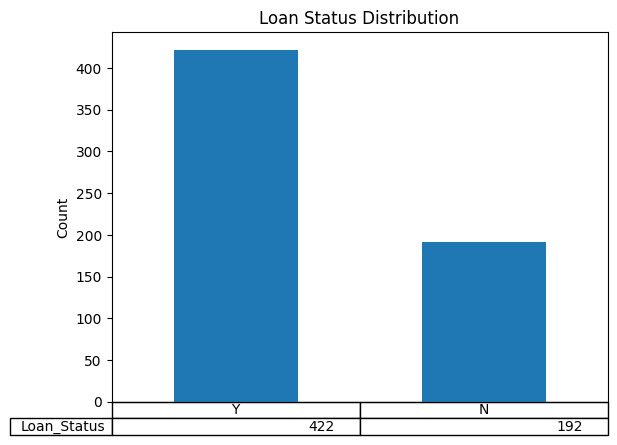

In [7]:
#let's graph the loan statuses

ax = df["Loan_Status"].value_counts().plot(kind='bar',ylabel="Count", 
                                      xlabel="Loan Approved", rot=360,
                                     title="Loan Status Distribution", table=True)
ax.get_xaxis().set_visible(False)   
plt.show()

We see from the above that our dataset is unbalanced. However, we should not be concerned as it is not severely imbalanced. We can proceed with it as is. If it becomes an issue we can try undersampling techniques for future models. 

It will be interesting to see if the intersection of education and gender change the loan status. We will graph it below.

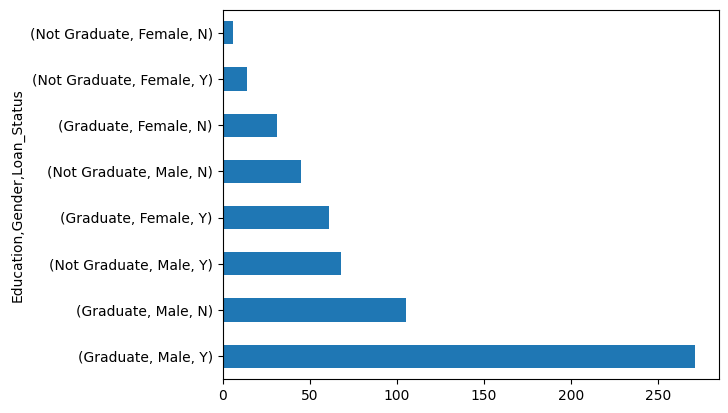

In [8]:
df[["Education","Gender","Loan_Status"]].value_counts().plot(kind="barh", subplots=True)
plt.show()

We see from the above that most of the people with approved loans are male college graduates. There are also a lot more men than women in our dataset overall. This suggests that perhaps women are less likely to seek home loans.

It is fascinating to see that there are more men without degrees that receive loans than there are female graduates that received loans. This could imply gender discrimination. However, we have not looked at differences in income and credit history. Moreover, this type of analysis is not the goal of our machine learning models. It remains an interesting question to ponder.

In [9]:
# before we move on, we should check for duplicates
df.duplicated().sum()

0

### Filling Missing (NaN) Values
We saw a lot of columns with NaN values. We can fill those missing values based on the proportion of the exising values since most of them are non-numeric. For the numeric columns, we will use the mean.

In [10]:
# generate a list of columns with NaN values
nan_columns = df.columns[df.isna().any()].tolist()
nan_columns

['Gender',
 'Married',
 'Dependents',
 'Self_Employed',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History']

In [11]:
# check to make sure these columns have NaNs
df[nan_columns].isna().sum()

Gender              13
Married              3
Dependents          15
Self_Employed       32
LoanAmount          22
Loan_Amount_Term    14
Credit_History      50
dtype: int64

In [12]:
df2 = df.copy()

In [13]:
# fill the nan columns with the mean of the other non-null values in those columns
# excluse Credit_History because it is a boolean

df2.loc[:,df2.columns!="Credit_History"] = df2.loc[:,df2.columns!="Credit_History"].fillna(df2.mean(numeric_only=True)) 

In [14]:
# let us make sure we removed the NaN values from those numeric columns
df2[nan_columns].isna().sum()

Gender              13
Married              3
Dependents          15
Self_Employed       32
LoanAmount           0
Loan_Amount_Term     0
Credit_History      50
dtype: int64

In [15]:
# let us start with imputing the Gender column
gender = df2["Gender"].value_counts(normalize=True)
gender

Male      0.813644
Female    0.186356
Name: Gender, dtype: float64

In [16]:
df2.loc[df2["Gender"].isna(), 'Gender'] = np.random.choice(gender.index, p=gender.values, size=df2["Gender"].isna().sum())
df2

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.000000,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.000000,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.000000,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.000000,360.0,1.0,Urban,Y


In [17]:
# sanity check
df2[nan_columns].isna().sum()

Gender               0
Married              3
Dependents          15
Self_Employed       32
LoanAmount           0
Loan_Amount_Term     0
Credit_History      50
dtype: int64

In [18]:
# imputing the Married column
married = df2["Married"].value_counts(normalize=True)
df2.loc[df2["Married"].isna(), 'Married'] = np.random.choice(married.index, p=married.values, size=df2["Married"].isna().sum())

df2[nan_columns].isna().sum()

Gender               0
Married              0
Dependents          15
Self_Employed       32
LoanAmount           0
Loan_Amount_Term     0
Credit_History      50
dtype: int64

In [19]:
# imputing the Dependents column
dependents = df2["Dependents"].value_counts(normalize=True)
df2.loc[df2["Dependents"].isna(), 'Dependents'] = np.random.choice(dependents.index, p=dependents.values, 
                                                                   size=df2["Dependents"].isna().sum())

df2[nan_columns].isna().sum()

Gender               0
Married              0
Dependents           0
Self_Employed       32
LoanAmount           0
Loan_Amount_Term     0
Credit_History      50
dtype: int64

In [20]:
# imputing the Self_Employed column
self_employed = df2["Self_Employed"].value_counts(normalize=True)
df2.loc[df2["Self_Employed"].isna(), 'Self_Employed'] = np.random.choice(self_employed.index, p=self_employed.values, 
                                                                   size=df2["Self_Employed"].isna().sum())

df2[nan_columns].isna().sum()

Gender               0
Married              0
Dependents           0
Self_Employed        0
LoanAmount           0
Loan_Amount_Term     0
Credit_History      50
dtype: int64

In [21]:
# imputing the Credit_History column
credit_history = df2["Credit_History"].value_counts(normalize=True)
df2.loc[df2["Credit_History"].isna(), 'Credit_History'] = np.random.choice(credit_history.index, p=credit_history.values, 
                                                                   size=df2["Credit_History"].isna().sum())

df2[nan_columns].isna().sum()

Gender              0
Married             0
Dependents          0
Self_Employed       0
LoanAmount          0
Loan_Amount_Term    0
Credit_History      0
dtype: int64

Great! We were able to impute all the missing values.

In [22]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         614 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [23]:
# split the data into X and Y

X = df2.iloc[:,0:-1]
y = df2.iloc[:, -1].values
y = np.where((y == "Y"), 1, 0)

In [24]:
print(X.shape)
print(y.shape)

(614, 12)
(614,)


In [25]:
# one-hot-encode the categorical columns
X = pd.get_dummies(X)

In [26]:
# save the column names for later
long_features = X.columns
X.shape

(614, 634)

In [27]:
# let us check the distribution of the data
X.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_ID_LP001002,Loan_ID_LP001003,Loan_ID_LP001005,Loan_ID_LP001006,Loan_ID_LP001008,...,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
count,614.000000,614.000000,614.000000,614.000000,614.00000,614.000000,614.000000,614.000000,614.000000,614.000000,...,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,5403.459283,1621.245798,146.412162,342.000000,0.84202,0.001629,0.001629,0.001629,0.001629,0.001629,...,0.174267,0.166124,0.089577,0.781759,0.218241,0.861564,0.138436,0.291531,0.379479,0.328990
std,6109.041673,2926.248369,84.037468,64.372489,0.36502,0.040357,0.040357,0.040357,0.040357,0.040357,...,0.379648,0.372495,0.285807,0.413389,0.413389,0.345639,0.345639,0.454838,0.485653,0.470229
min,150.000000,0.000000,9.000000,12.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2877.500000,0.000000,100.250000,360.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,3812.500000,1188.500000,129.000000,360.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,5795.000000,2297.250000,164.750000,360.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We can see that there is a wide distribution and not all the features are on the same scale. We will need to scale the features.

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [29]:
# let us first split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
# check that the splitting worked correctly
print("X Training Shape:", X_train.shape)
print("Y Training Shape:", y_train.shape)
print("X Test Shape:", X_test.shape)
print("Y Test Shape:", y_test.shape)

X Training Shape: (429, 634)
Y Training Shape: (429,)
X Test Shape: (185, 634)
Y Test Shape: (185,)


In [31]:
# Creating a scaler object
scaler = StandardScaler() 

# Fitting and transforming the original data to scaled data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Now that we split our data into training, and testing sets, we can begin building our models. We will start with a logistic regression.

## Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression

In [33]:
# lists for the regularization strength and the different solvers
strength = [0.001, 0.01, 0.1, 1, 10]
solvers = ["lbfgs", "liblinear","saga", "sag", "newton-cg"]

To more efficiently find the right fit, solver, and C value for our logistic regression, we will leverage the GridSearchCV function.

In [34]:
from sklearn.model_selection import GridSearchCV

### L2 Regularization

In [35]:
# L2 regularization GridSearch
parameters = {"C":strength, "solver":solvers,
              "random_state":[42], "max_iter":[3000], "penalty":["l2"]}
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [3000],
                         'penalty': ['l2'], 'random_state': [42],
                         'solver': ['lbfgs', 'liblinear', 'saga', 'sag',
                                    'newton-cg']})

In [36]:
# the saga solver had the best score with L2 at a C level of 1
clf.best_params_, clf.best_score_

({'C': 1,
  'max_iter': 3000,
  'penalty': 'l2',
  'random_state': 42,
  'solver': 'saga'},
 0.8041586867305062)

### L1 Regularization

In [37]:
# L1 regularization
parameters2 = {"C":strength, "solver":["liblinear","saga"],
              "random_state":[42], "max_iter":[7000], "penalty":["l1"]}
lr2 = LogisticRegression()
clf2 = GridSearchCV(lr2, parameters2)
clf2.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [7000],
                         'penalty': ['l1'], 'random_state': [42],
                         'solver': ['liblinear', 'saga']})

In [38]:
clf2.best_params_, clf2.best_score_

({'C': 0.1,
  'max_iter': 7000,
  'penalty': 'l1',
  'random_state': 42,
  'solver': 'liblinear'},
 0.8088372093023256)

Liblinear with L1 has a slightly higher accuracy score. However, we should be mindful of overfitting. We will fit individual models and check their accuracy scores.

In [39]:
# create a new logreg instance
saga = LogisticRegression()

In [40]:
# set the parameters to be equal to the best parameters from our first GridSearch
saga.set_params(**clf.best_params_)

LogisticRegression(C=1, max_iter=3000, random_state=42, solver='saga')

In [41]:
# sanity check
saga.get_params()

{'C': 1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 3000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [42]:
saga.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=3000, random_state=42, solver='saga')

In [43]:
# test the model for training and testing accuracy
print("Training Accuracy:", saga.score(X_train, y_train))
print("Testing Accuracy:", saga.score(X_test, y_test))

Training Accuracy: 1.0
Testing Accuracy: 0.7297297297297297


Our model for saga is overfitting. The training accuracy is perfect while the testing accuracy is lower than what we saw for our GridSearch. Let us see if liblinear does any better.

In [44]:
liblinear = LogisticRegression()

In [45]:
liblinear.set_params(**clf2.best_params_)
liblinear.get_params()

{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 7000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': 42,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [46]:
liblinear.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=7000, penalty='l1', random_state=42,
                   solver='liblinear')

In [47]:
# test the model for training and testing accuracy
print("Training Accuracy:", liblinear.score(X_train, y_train))
print("Testing Accuracy:", liblinear.score(X_test, y_test))

Training Accuracy: 0.9766899766899767
Testing Accuracy: 0.7675675675675676


We have the same issue where liblinear is also overfitting. I wonder if removing the loan_id would help at all.

In [48]:
X2 = df2.iloc[:,0:-1]

In [49]:
X2.pop("Loan_ID")

0      LP001002
1      LP001003
2      LP001005
3      LP001006
4      LP001008
         ...   
609    LP002978
610    LP002979
611    LP002983
612    LP002984
613    LP002990
Name: Loan_ID, Length: 614, dtype: object

In [50]:
X2 = pd.get_dummies(X2)
short_features = X2.columns # save for later

In [51]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.3, random_state=42)

In [52]:
# scale the features
scaler2 = StandardScaler() 

# Fitting and transforming the original data to scaled data
X_train2 = scaler2.fit_transform(X_train2)
X_test2 = scaler2.transform(X_test2)

In [53]:
parameters3 = {"C":strength, "solver":solvers,
              "random_state":[42], "max_iter":[3000], "penalty":["l2"]}
lr3 = LogisticRegression()
clf3 = GridSearchCV(lr3, parameters3)
clf3.fit(X_train2, y_train2)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [3000],
                         'penalty': ['l2'], 'random_state': [42],
                         'solver': ['lbfgs', 'liblinear', 'saga', 'sag',
                                    'newton-cg']})

In [54]:
clf3.best_params_, clf3.best_score_

({'C': 0.01,
  'max_iter': 3000,
  'penalty': 'l2',
  'random_state': 42,
  'solver': 'liblinear'},
 0.8065116279069768)

### L1 Regularization

In [55]:
parameters4 = {"C":strength, "solver":["liblinear","saga"],
              "random_state":[42], "max_iter":[3000], "penalty":["l1"]}
lr4 = LogisticRegression()
clf4 = GridSearchCV(lr4, parameters4)
clf4.fit(X_train2, y_train2)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [3000],
                         'penalty': ['l1'], 'random_state': [42],
                         'solver': ['liblinear', 'saga']})

In [56]:
clf4.best_params_, clf4.best_score_

({'C': 0.1,
  'max_iter': 3000,
  'penalty': 'l1',
  'random_state': 42,
  'solver': 'liblinear'},
 0.8088372093023256)

### Verify Results Using the Test Set

In [57]:
lbfgs = LogisticRegression()
lbfgs.set_params(**clf3.best_params_)
lbfgs.get_params()

{'C': 0.01,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 3000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [58]:
lbfgs.fit(X_train2, y_train2)

LogisticRegression(C=0.01, max_iter=3000, random_state=42, solver='liblinear')

In [59]:
# test the model for training and testing accuracy
print("Training Accuracy:", lbfgs.score(X_train2, y_train2))
print("Testing Accuracy:", lbfgs.score(X_test2, y_test2))

Training Accuracy: 0.8088578088578089
Testing Accuracy: 0.7675675675675676


### Observation

This simplified model does not appear to be overfitting while maintaining a similar test accuracy. Let us see how the second liblinear model performs.

In [60]:
liblinear2 = LogisticRegression()
liblinear2.set_params(**clf4.best_params_)
liblinear2.get_params()
liblinear2.fit(X_train2, y_train2)

LogisticRegression(C=0.1, max_iter=3000, penalty='l1', random_state=42,
                   solver='liblinear')

In [61]:
# test the model for training and testing accuracy
print("Training Accuracy:", liblinear2.score(X_train2, y_train2))
print("Testing Accuracy:", liblinear2.score(X_test2, y_test2))

Training Accuracy: 0.8088578088578089
Testing Accuracy: 0.7675675675675676


### Classification Reports

In [62]:
y_pred = lbfgs.predict(X_test2)
print("Lbfgs Classification Report:")
print(classification_report(y_test2, y_pred, target_names=("No","Yes")))

Lbfgs Classification Report:
              precision    recall  f1-score   support

          No       0.84      0.42      0.56        65
         Yes       0.75      0.96      0.84       120

    accuracy                           0.77       185
   macro avg       0.80      0.69      0.70       185
weighted avg       0.78      0.77      0.74       185



In [63]:
y_pred2 = liblinear2.predict(X_test2)
print("Liblinear L1 Classification Report:")
print(classification_report(y_test2, y_pred2, target_names=("No","Yes")))

Liblinear L1 Classification Report:
              precision    recall  f1-score   support

          No       0.84      0.42      0.56        65
         Yes       0.75      0.96      0.84       120

    accuracy                           0.77       185
   macro avg       0.80      0.69      0.70       185
weighted avg       0.78      0.77      0.74       185



### Important Features

In [83]:
# Create a dataframe that maps the feature names to the coefficients
lbfgs_coef = pd.DataFrame(data=abs(lbfgs.coef_), columns=short_features)

# Transpose the DF to make it easier to read
lbfgs_coef = lbfgs_coef.T
lbfgs_coef.rename(columns={0:"Features"},inplace=True)

# Sorting the top features by coefficient values
lbfgs_coef = lbfgs_coef.sort_values(by="Features",ascending=False).head(20)
lbfgs_coef

,Features
Credit_History,0.480937
Property_Area_Semiurban,0.128386
Property_Area_Rural,0.075315
Dependents_1,0.071808
Married_No,0.069565
Married_Yes,0.069565
Property_Area_Urban,0.060680
Dependents_2,0.042007
Dependents_3+,0.038169
ApplicantIncome,0.026970


In [71]:
# Create a dataframe that maps the feature names to the coefficients
liblinear_coef = pd.DataFrame(data=abs(liblinear2.coef_), columns=short_features)

# Transpose the DF to make it easier to read
liblinear_coef = liblinear_coef.T
liblinear_coef.rename(columns={0:"Features"},inplace=True)

# Sorting the top features by coefficient values
liblinear_coef = liblinear_coef.sort_values(by="Features",ascending=False).head(20)
liblinear_coef

,Features
Credit_History,0.944062
Property_Area_Semiurban,0.245575
Married_No,0.104645
Dependents_1,0.055334
Married_Yes,0.016578
Dependents_3+,0.000000
Property_Area_Rural,0.000000
Self_Employed_Yes,0.000000
Self_Employed_No,0.000000
Education_Not Graduate,0.000000


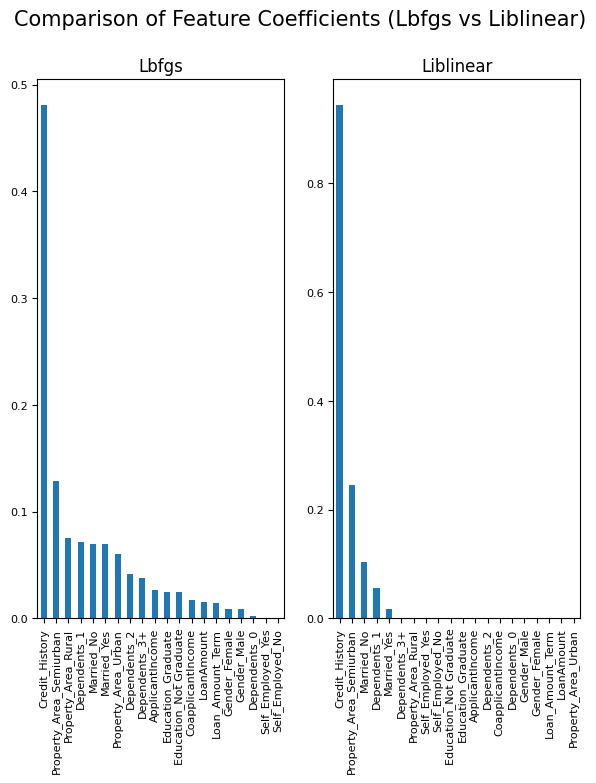

In [84]:
# compare Lbfgs vs Liblinear feature weights

fig1, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2)
fig1.suptitle('Comparison of Feature Coefficients (Lbfgs vs Liblinear)', fontsize=15)

lbfgs_coef.plot(ax=ax1, kind="bar", figsize=(7,7), title="Lbfgs", legend=False, fontsize=8)
liblinear_coef.plot(ax=ax2, kind="bar", figsize=(7,7), title="Liblinear", legend=False, fontsize=8)

plt.show()

Both of these models perform roughly at the same accuracy as the previous two without overfitting. That is a good sign. However, our overall accuracy is still relatively low. Comparing the most highly weighted features, we see that both of them chose Credit_History and Property_Area_Semiurban as the two most important features. Additionally, the first model has all of the second model's features in its top six. We can try fitting a model on only those six top features to see how it performs.

## Feature Selection

In [111]:
# create a new X and one-hot-encode
X3 = df2.iloc[:,0:-1]
X3 = pd.get_dummies(X3)

In [114]:
# only grab the top six columns and assign it back to X3
top_coef = list(lbfgs_coef.index[0:6])
X3 = X3[top_coef]

In [116]:
# split the data
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y, test_size=0.3, random_state=42)

In [117]:
# Creating a scaler object
scaler3 = StandardScaler() 

# Fitting and transforming the original data to scaled data
X_train3 = scaler3.fit_transform(X_train3)
X_test3 = scaler3.transform(X_test3)

In [118]:
parameters5 = {"C":strength, "solver":solvers,
              "random_state":[42], "max_iter":[3000], "penalty":["l2"]}
lr5 = LogisticRegression()
clf5 = GridSearchCV(lr5, parameters5)
clf5.fit(X_train3, y_train3)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [3000],
                         'penalty': ['l2'], 'random_state': [42],
                         'solver': ['lbfgs', 'liblinear', 'saga', 'sag',
                                    'newton-cg']})

In [120]:
clf5.best_params_, clf5.best_score_

({'C': 0.01,
  'max_iter': 3000,
  'penalty': 'l2',
  'random_state': 42,
  'solver': 'liblinear'},
 0.8088372093023256)

In [121]:
liblinear3 = clf5.best_estimator_
liblinear3.fit(X_train3, y_train3)

LogisticRegression(C=0.01, max_iter=3000, random_state=42, solver='liblinear')

In [122]:
# test the model for training and testing accuracy
print("Training Accuracy:", liblinear3.score(X_train3, y_train3))
print("Testing Accuracy:", liblinear3.score(X_test3, y_test3))

Training Accuracy: 0.8088578088578089
Testing Accuracy: 0.7675675675675676


Wow! Interestingly, removing all the other features resulted in the same accuracy score. However, I will note that the GridSearch returned liblinear which is the model that only use five features. Therefore, it makes sense that it would produce a similar or identical score.

## SVM

We will now train our models using SVM. We will continue with the modified and simplified features that exclude the loan ID.

In [109]:
from sklearn import svm

In [110]:
svm_params = {"kernel":["linear", "rbf", "poly", "sigmoid"], "random_state":[42], "C":strength}

svc = svm.SVC()
svc_svm = GridSearchCV(svc, svm_params)

In [111]:
svc_svm.fit(X_train2, y_train2)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                         'random_state': [42]})

In [112]:
svc_svm.best_params_, svc_svm.best_score_

({'C': 0.01, 'kernel': 'linear', 'random_state': 42}, 0.8088098495212039)

The linear kernel performed best at a regularization strength of 0.01. Let us check if there is overfitting.

In [113]:
svclinear = svm.SVC()
svclinear.set_params(**svc_svm.best_params_)
svclinear.get_params()

{'C': 0.01,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [114]:
svclinear.fit(X_train2, y_train2)

SVC(C=0.01, kernel='linear', random_state=42)

In [115]:
# test the model for training and testing accuracy
print("Training Accuracy:", svclinear.score(X_train2, y_train2))
print("Testing Accuracy:", svclinear.score(X_test2, y_test2))

Training Accuracy: 0.8088578088578089
Testing Accuracy: 0.7783783783783784


The results are identical to our logistic regression using liblinear. 

## Decision Trees

Now we will continue our analysis using decision tree classifiers.

In [116]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [117]:
# create a list of max depths to test
depths = [1,3,6,9,12,15,18]

In [122]:
tree_params = {"criterion":["gini", "entropy"], "random_state":[42], "max_depth":depths}

dtc = DecisionTreeClassifier()
tree_classifier = GridSearchCV(dtc, tree_params, cv=5)

In [123]:
tree_classifier.fit(X_train2, y_train2)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 3, 6, 9, 12, 15, 18],
                         'random_state': [42]})

In [124]:
tree_classifier.best_params_, tree_classifier.best_score_

({'criterion': 'gini', 'max_depth': 1, 'random_state': 42}, 0.8088098495212039)

In [131]:
gini = tree_classifier.best_estimator_

In [132]:
gini.fit(X_train2, y_train2)

DecisionTreeClassifier(max_depth=1, random_state=42)

In [133]:
# test the model for training and testing accuracy
print("Training Accuracy:", gini.score(X_train2, y_train2))
print("Testing Accuracy:", gini.score(X_test2, y_test2))

Training Accuracy: 0.8088578088578089
Testing Accuracy: 0.7783783783783784


Once again our accuracy scores are identical. It is odd that the highest score was reached at max depth of 1. That seems like it should not happen. For curiousity, let us try manually using different max depths to see what the scores are.

In [135]:
# change the depth to 3
gini.max_depth = 3
gini.get_params()

In [139]:
# fit again
gini.fit(X_train2, y_train2)

# test the model for training and testing accuracy
print("Training Accuracy:", gini.score(X_train2, y_train2))
print("Testing Accuracy:", gini.score(X_test2, y_test2))

Training Accuracy: 0.8228438228438228
Testing Accuracy: 0.7783783783783784


In [140]:
gini.max_depth = 18
gini.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 18,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [141]:
# fit again
gini.fit(X_train2, y_train2)

# test the model for training and testing accuracy
print("Training Accuracy:", gini.score(X_train2, y_train2))
print("Testing Accuracy:", gini.score(X_test2, y_test2))

Training Accuracy: 1.0
Testing Accuracy: 0.6702702702702703


Increasing our max depth improved the training accuracy but either did not affect the testing or decreased altogether. It seems that the GridSearchCV did identify the highest performing tree depth.

We know that decision trees are scalable. Perhaps, we can try using the unscaled dataset to see if it makes a difference.

In [148]:
X4 = df2.iloc[:,0:-1]
X4 = pd.get_dummies(X4)

In [149]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y, test_size=0.3, random_state=42)

In [151]:
# fit again using the unscaled features
gini.max_depth = 1
gini.fit(X_train4, y_train4)

# test the model for training and testing accuracy
print("Training Accuracy:", gini.score(X_train4, y_train4))
print("Testing Accuracy:", gini.score(X_test4, y_test4))

Training Accuracy: 0.8088578088578089
Testing Accuracy: 0.7783783783783784


In [152]:
gini.max_depth = 3
gini.fit(X_trai43, y_train4)

# test the model for training and testing accuracy
print("Training Accuracy:", gini.score(X_train4, y_train4))
print("Testing Accuracy:", gini.score(X_test4, y_test4))

Training Accuracy: 0.8228438228438228
Testing Accuracy: 0.7837837837837838


In [158]:
gini.max_depth = 5
gini.fit(X_train4, y_train4)

# test the model for training and testing accuracy
print("Training Accuracy:", gini.score(X_train4, y_train4))
print("Testing Accuracy:", gini.score(X_test4, y_test4))

Training Accuracy: 0.8321678321678322
Testing Accuracy: 0.7783783783783784


At max depth of 3, we saw the highest testing accuracy so far. We used the unscaled features and it seemed to help a little bit. However, we have yet to hit 80 percent for any of our models. We will try ensemble methods next.

## Gradient Boosting

In [159]:
from sklearn.ensemble import GradientBoostingClassifier

In [163]:
gbc_parameters = {"n_estimators":[100, 150, 200], "learning_rate":[0.001, 0.01, 0.1, 1,10], "random_state":[42], 
                  "max_depth":depths}

gbc = GradientBoostingClassifier()
gb_classifier = GridSearchCV(gbc, gbc_parameters, cv=5)

In [164]:
gb_classifier.fit(X_train2, y_train2)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1, 10],
                         'max_depth': [1, 3, 6, 9, 12, 15, 18],
                         'n_estimators': [100, 150, 200],
                         'random_state': [42]})

In [165]:
gb_classifier.best_params_, gb_classifier.best_score_

({'learning_rate': 0.01,
  'max_depth': 1,
  'n_estimators': 100,
  'random_state': 42},
 0.8088098495212039)

In [166]:
gbc_model = gb_classifier.best_estimator_

gbc_model.fit(X_train2, y_train2)

# test the model for training and testing accuracy
print("Training Accuracy:", gbc_model.score(X_train2, y_train2))
print("Testing Accuracy:", gbc_model.score(X_test2, y_test2))

Training Accuracy: 0.8088578088578089
Testing Accuracy: 0.7783783783783784


In [167]:
# let us do a gridsearch with the unscaled data

gbc_parameters = {"n_estimators":[100, 150, 200], "learning_rate":[0.001, 0.01, 0.1, 1,10], "random_state":[42], 
                  "max_depth":depths}

gbc2 = GradientBoostingClassifier()
gb_classifier2 = GridSearchCV(gbc2, gbc_parameters, cv=5)

gb_classifier2.fit(X_train4, y_train4)

gb_classifier2.best_params_, gb_classifier2.best_score_

({'learning_rate': 0.01,
  'max_depth': 1,
  'n_estimators': 100,
  'random_state': 42},
 0.8088098495212039)

In [168]:
gbc_model2 = gb_classifier2.best_estimator_

gbc_model2.fit(X_train4, y_train4)

# test the model for training and testing accuracy
print("Training Accuracy:", gbc_model2.score(X_train4, y_train4))
print("Testing Accuracy:", gbc_model2.score(X_test4, y_test4))

Training Accuracy: 0.8088578088578089
Testing Accuracy: 0.7783783783783784


Our multiple attempts with gradient boosting resulted in the same accuracy as before.

## Multi-layer Perceptron (MLP) Neural Network Classifier

We now move on to our final model for this analysis. MLP is a perceptron model that contains multiple layers thus allowing it to learn non-linear relationships. It works for both regression and classification problems. We will experiment to see if it can improve upon the results of previous models. If not, it is possible that our dataset needs additional transformations.

In [169]:
from sklearn.neural_network import MLPClassifier

In [178]:
# MLP requires scaled data so we will use the scaled version here

alpha = 10.0 ** -np.arange(1, 7)

mlp_parameters = {"activation":['identity', 'logistic', 'tanh', 'relu'], 
                  "solver":['adam', 'lbfgs', 'sgd'], 
                  "hidden_layer_sizes":[(15,), (30,), (60,), (100,)], 
                  "alpha":alpha,
                  "random_state":[42], "max_iter":[10000]}

mlp = MLPClassifier()
mlp_classifier = GridSearchCV(mlp, mlp_parameters, cv=5, error_score='raise')

In [179]:
mlp_classifier.fit(X_train2, y_train2)

GridSearchCV(cv=5, error_score='raise', estimator=MLPClassifier(),
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06]),
                         'hidden_layer_sizes': [(15,), (30,), (60,), (100,)],
                         'max_iter': [10000], 'random_state': [42],
                         'solver': ['adam', 'lbfgs', 'sgd']})

In [180]:
mlp_classifier.best_params_, mlp_classifier.best_score_

({'activation': 'identity',
  'alpha': 0.1,
  'hidden_layer_sizes': (100,),
  'max_iter': 10000,
  'random_state': 42,
  'solver': 'sgd'},
 0.8088098495212039)

In [191]:
mlp_model = mlp_classifier.best_estimator_

In [192]:
mlp_model.fit(X_train2, y_train2)

MLPClassifier(activation='identity', alpha=0.1, max_iter=100000,
              random_state=42, solver='sgd')

In [193]:
# test the model for training and testing accuracy
print("Training Accuracy:", mlp_model.score(X_train2, y_train2))
print("Testing Accuracy:", mlp_model.score(X_test2, y_test2))

Training Accuracy: 0.8088578088578089
Testing Accuracy: 0.7783783783783784


In [204]:
y_pred = mlp_model.predict(X_test2)
print("MLP Classification Report:")
print(classification_report(y_test2, y_pred, target_names=("No","Yes")))

MLP Classification Report:
              precision    recall  f1-score   support

          No       0.88      0.43      0.58        65
         Yes       0.76      0.97      0.85       120

    accuracy                           0.78       185
   macro avg       0.82      0.70      0.71       185
weighted avg       0.80      0.78      0.75       185

